In [67]:
import pandas
import numpy as np
import matplotlib
import seaborn
import os
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import precision_score, recall_score, f1_score



In [2]:
mom_sample_path="./converted_mom/sen_1.wav"
me_sample_path="./converted_me/sen_1.wav"

In [3]:
#ipd.Audio(mom_sample_path)

In [4]:
#ipd.Audio(me_sample_path)

In [5]:
#load the audio files
mom_sample_loaded, sr=librosa.load(mom_sample_path)
me_sample_loaded, _=librosa.load(me_sample_path)
#these are now a numpy array - the wave form associated with the audio file

print("----the numuber of samples in the audio sample 1-----")
print("    mom sample: ",mom_sample_loaded.shape[0])
print("    me sample: ",me_sample_loaded.shape[0])


----the numuber of samples in the audio sample 1-----
    mom sample:  209428
    me sample:  228391


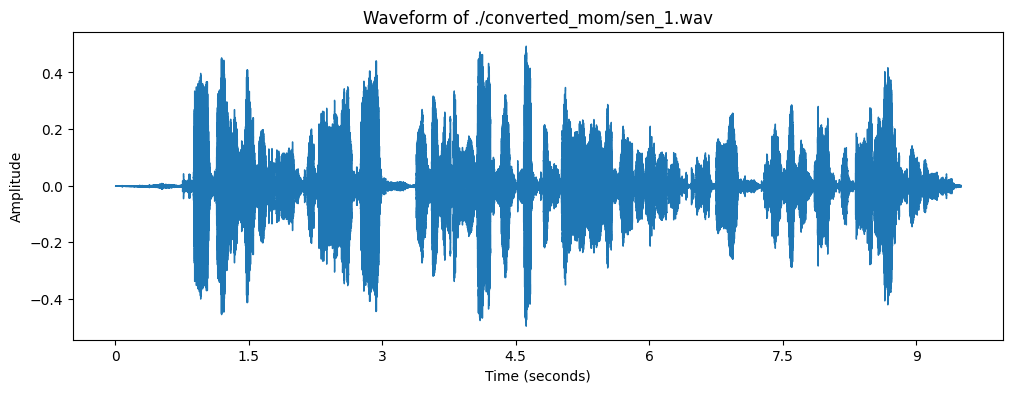

In [6]:
# Load the WAV file
wav_file = mom_sample_path
y, sr = librosa.load(wav_file)

# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of {}'.format(wav_file))
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

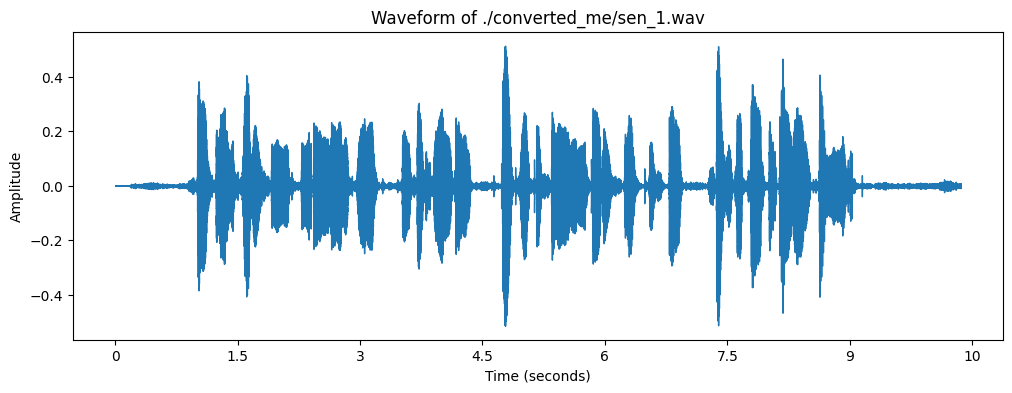

In [7]:
# Load the WAV file
wav_file = me_sample_path
y, sr = librosa.load(wav_file)

# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of {}'.format(wav_file))
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

We can see that the datapoints have different waveforms when both individuals are saying the same sentence; thus, there are features to make them noticable from each other. However across the dataset, the wave forms may differ due to the different sentences being pronounced in different samples. (Above is only sentence number 1 out of the 25 sentences in the dataset.)

In order to limit the effect of different sentences, we move to a frequncey-magnitude plot below, in which we see the magnitude of different frequencies in the audio file overall. Thus the time aspect is out of our next plot; however it is importnat to note that the longer the audio file is, the more of each frequency can exist (probability of a seeing a frequency in an audio increases and we would need a normalisation method to account for that. But this is not what we are lookign at below.)

What we have below, derived from using the Fast Fourier Transform (FFT), is the energy of each frequency over the audio file, meaning the energy that the specific frequency had in condencing the air molecules between the speaker and the recorder. (or the pressure it created in the air molecules.)

In [8]:
def plot_magnitude_spectrum(signal, title, sr, f_ratio=0.5):
    """
    Plotting the magnitude spectrum of a signal

    Parameters
    ----------
    signal : numpy array
        The signal to be plotted
    title : string
        The title of the plot
    sr : int
        The sampling rate of the signal
    f_ratio : float
        The ratio of the frequency bins to be plotted (default is 0.5)
        reason explained in the comments below
    """
    X = np.fft.fft(signal) # Fourier Transform calculation
    mag_spec = np.absolute(X) # Magnitude calculation
    
    plt.figure(figsize=(17, 4))
    
    freq = np.linspace(0, sr, len(mag_spec)) #creating the frequency bins associated with the magnitude values
    freq_bins = int(len(mag_spec)*0.5)  #only plotting the first half of the spectrum
                                    #(the second half is a mirror image of the first half) - theorem of Nyquist
    
    plt.plot(freq[:freq_bins], mag_spec[:freq_bins]) #slicing the frequency and magnitude arrays to plot
                                                    #only the first half (by defult)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(title)

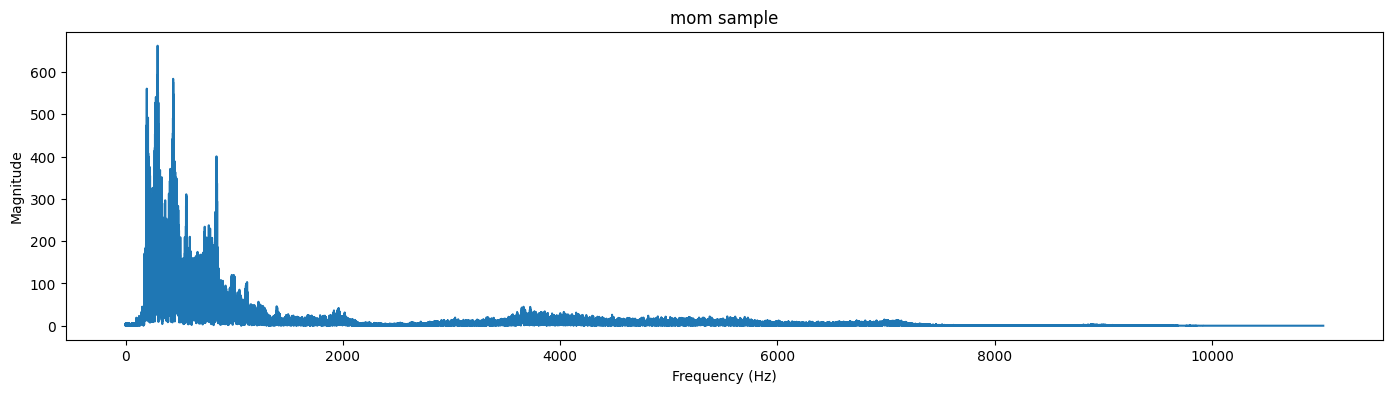

In [9]:
plot_magnitude_spectrum(mom_sample_loaded, "mom sample", sr)


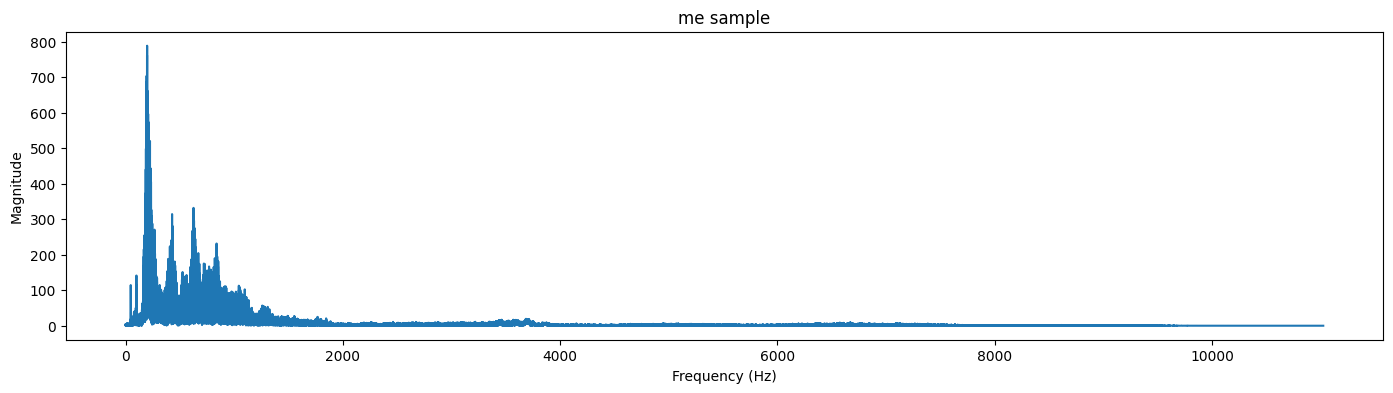

In [10]:
plot_magnitude_spectrum(me_sample_loaded, "me sample", sr)

We can see above the the magnitude of the frequencies differ between the datapoint that belongs to me and the datapoint blonging to my  mother (their energy - not in decibell scale here).

This is one way we can identify these two audios from each other as a human. we can see the highest magnitudes reached in both audios are nearly havingthe same frequencies but in my audio the peak is higher and has a larger difference with the rest of the peaks while in my mother's the peaks are less in terms of magnitude and more frequencies reach to high magnitudes.

In [11]:
def extract_features(audio_file_path):
    """
    Extracting the RMS and ZCR features from an audio file

    Parameters
    ----------
    audio_file_path : string
        The path to the audio file
    
    Returns
    -------
    RMS : numpy array
        The RMS values of the audio file
    ZCR : numpy array
        The ZCR values of the audio file
    """
    audio_file, _ = librosa.load(audio_file_path)
    FRAME_SIZE = 1024 #explained below
    HOP_LENGTH = 512 #explained below
    RMS=librosa.feature.rms(y=audio_file, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    ZCR=librosa.feature.zero_crossing_rate(y=audio_file, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    return RMS, ZCR

    #add  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)!!!!!!!!!!!!!!!!!!!!!!!!

- FRAME_SIZE = 1024

    - This value represents the number of samples in each audio frame. Choosing a small frame size allows for more temporal resolution but less frequency resolution, while a larger frame size allows for more frequency resolution but less temporal resolution. A frame size of 1024 strikes a balance between the two.
<br>
<br>
- HOP_LENGTH = 512

    - This value represents the number of samples to shift the frame window after each frame. A hop length of 512 is chosen because it provides a good balance between temporal resolution and computational efficiency.

In [12]:
# the sample number 12 is chosen since the duration of the two categories are
# very similar (visible from the scatter plot)
RMS_mom_sample, ZCR_mom_sample=extract_features("./converted_mom/sen_12.wav")
RMS_me_sample, ZCR_me_sample=extract_features("./converted_me/sen_12.wav")
print("---Root-mean-square value on average (RMS)---")
print("     avg RMS_mom_sample: ",np.mean(RMS_mom_sample))
print("     avg RMS_me_sample: ",np.mean(RMS_me_sample))
print("\n") #line break
print("---Zero-crossing rate (ZCR)---")
print("     avg ZCR_mom_sample: ",np.mean(ZCR_mom_sample))
print("     avg ZCR_me_sample: ",np.mean(ZCR_me_sample))



---Root-mean-square value on average (RMS)---
     avg RMS_mom_sample:  0.110080235
     avg RMS_me_sample:  0.06244816


---Zero-crossing rate (ZCR)---
     avg ZCR_mom_sample:  0.08379259528423773
     avg ZCR_me_sample:  0.05375819052419355


we can see that it is rather a fundamental difference between our audios that is due to the pace of our speech.

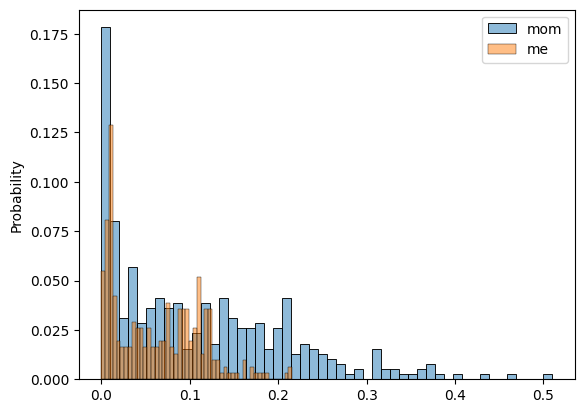

In [91]:
seaborn.histplot(
    data=RMS_mom_sample.flatten(),
    stat='probability', alpha=0.5, label='mom',bins=50
)

seaborn.histplot(
    data=RMS_me_sample.flatten(),
    stat='probability', alpha=0.5, label='me',bins=50
)

plt.legend()

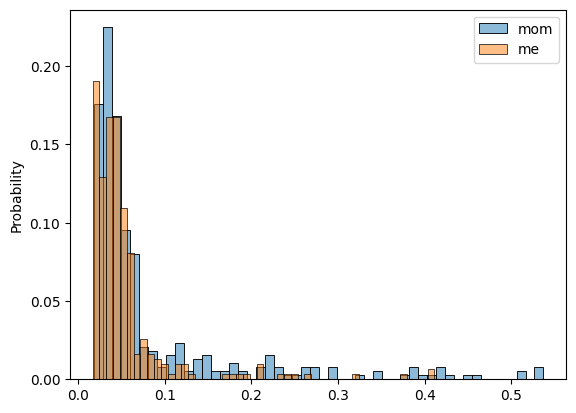

In [90]:
seaborn.histplot(
    data=ZCR_mom_sample.flatten(),
    stat='probability', alpha=0.5, label='mom', bins=50
)

seaborn.histplot(
    data=ZCR_me_sample.flatten(),
    stat='probability', alpha=0.5, label='me', bins=50
)
plt.legend()

Both RMS and ZCR of my mother's audio in the sample datapoint that we are looking at, are higher than my audio sample.
- The zero-crossing rate (ZCR) is a commonly used feature in audio signal processing that measures the number of times the audio waveform crosses the zero amplitude axis per unit time. In other words, it counts the number of times the audio waveform changes its polarity from positive to negative or vice versa. The ZCR is a useful indicator of the frequency content of an audio signal, as it tends to be higher for signals with high frequency content and lower for signals with low frequency content. For example, a high-pitched sound such as a flute or a whistle will have a higher ZCR than a low-pitched sound such as a bass guitar or a drum.

- The root-mean-square (RMS) is a commonly used feature in audio signal processing that measures the "loudness" or energy of an audio signal. It is calculated by taking the square root of the mean of the squared amplitude values of an audio signal. Having a higher average RMS in an audio signal means that the signal has a higher overall energy or loudness. This could be due to a number of factors, such as the presence of louder sounds or instruments, a higher number of audio tracks playing simultaneously, or simply a higher gain or volume level. It's worth noting that while a higher RMS value generally indicates a louder audio signal, it's not necessarily a direct measure of perceived loudness, as the human perception of loudness can be influenced by a number of other factors such as frequency content and duration of the audio signal. (more detail in phon measure)

In [15]:
#set the base directory
base_directory="/Users/shaghayeghmoradirad/Documents/GitHub/Pipeline_final/"

#set the mom and me folder names
mom_folder="converted_mom"
me_folder="converted_me"

#set the mom and me paths
mom_paths=os.path.join(base_directory,mom_folder)
me_paths=os.path.join(base_directory,me_folder)


In [16]:
def list_dur_all_audios(folder_path):
    """
    Calculating the average duration of all the audio files in a folder

    Parameters
    ----------
    folder_path : string
        The path to the folder containing the audio files
    
    Returns
    -------
    avg_dur : float
        The average duration of all the audio files in the folder
    """
    audios = []
    audios_dur_list = []
    for root, dirs, files in os.walk(folder_path, topdown=False):
        for name in files:
            try:
                audio = librosa.load(os.path.join(root, name))[0]
                audio_dur=librosa.get_duration(y=audio)
                audios_dur_list.append(audio_dur)
            except:
                continue
    return audios_dur_list

def avg_list(list_to_average):
    return sum(list_to_average)/len(list_to_average)

print("----the avg. duration of the audio files-----")
print("    mom avg. audios duration: ",avg_list(list_dur_all_audios(mom_paths)))
print("    me avg. audio duration: ",avg_list(list_dur_all_audios(me_paths)))

----the avg. duration of the audio files-----
    mom avg. audios duration:  7.689068480725625


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


    me avg. audio duration:  6.750668480725624


 mom avg. audios duration:  7.689068480725625

 me avg. audio duration:  6.750668480725624

 
We can see above that the average duration of my audio files are lower than my mother's; we can look at the durations in each file as well, in order to see if the lower average is due to an outlier.

In [17]:
list_dur_all_audios_mom=list_dur_all_audios(mom_paths)
list_dur_all_audios_me=list_dur_all_audios(me_paths)

#uncomment the following lines to see the duration of the audio files one by one

# print("----the duration of the audio files one by one-----")
# print("    mom audios duration: ",list_dur_all_audios_mom)
# print("    me audio duration: ",list_dur_all_audios_me)

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


<function matplotlib.pyplot.show(close=None, block=None)>

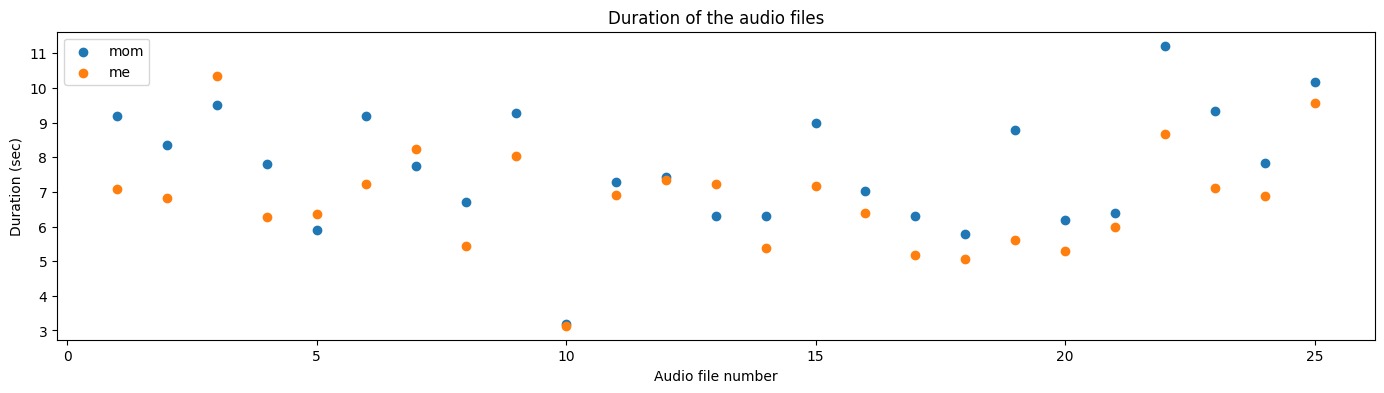

In [18]:
#plot the duration of my audios vs. my mother's audios
plt.figure(figsize=(17, 4))
audio_num_mom=range(1,len(list_dur_all_audios_mom)+1)
audio_num_me=range(1,len(list_dur_all_audios_me)+1)
plt.scatter(audio_num_mom ,list_dur_all_audios_mom ,label="mom")
plt.scatter(audio_num_me,list_dur_all_audios_me, label="me")
plt.xlabel('Audio file number')
plt.ylabel('Duration (sec)')
plt.title("Duration of the audio files")
plt.legend()
plt.show

We can see in the 25 sentences that most of the time, my mother's audio samples are longer/have more duration compared to mine; sometimes this difference is high and sometimes lower. Thus we could either do padding and cutting audios to the max or the average audio. (This would allow pace to be an effective factor in the learning.)

Or we can remove the effect of time by getting the average and stnadard deviation of a select group of features of the audios and then using those values to train the model. (This way we are learning to reconize the person regardless of the length of their sample audio which is desired in the assignment.)

In [19]:
def feature_vec_gen(audio_path):
    """
    Generating the feature vector from an audio file

    Parameters
    ----------
    audio_path : string
        The path to the audio file
    
    Returns
    -------
    vector_features : numpy array
        The feature vector of the audio file
    """
    RMS=extract_features(audio_path)[0]
    ZCR=extract_features(audio_path)[1]
    RMS_avg=np.mean(RMS)
    ZCR_avg=np.mean(ZCR)
    RMS_sd=np.std(RMS)
    ZCR_sd=np.std(ZCR)
    vector_features=np.array([RMS_avg,RMS_sd,ZCR_avg,ZCR_sd])
    return vector_features


In [20]:
feature_vec_gen(me_sample_path)

array([0.04598696, 0.04231095, 0.07180028, 0.09389614])

In [21]:
def path_vec_gen(folderpath):
    """
    Generating the feature vectors and the paths of the audio files in a folder

    Parameters
    ----------
    folderpath : string
        The path to the folder containing the audio files
    
    Returns
    -------
    audios_vecs : list
        The list of the feature vectors of the audio files in the folder
    audios_path : list
        The list of the paths of the audio files in the folder
    """
    audios_vecs = []
    audios_path = []
    for root, dirs, files in os.walk(folderpath, topdown=False):
        for name in files:
            file_path=os.path.join(root, name)
            try:
                data = feature_vec_gen(file_path)
                audios_path.append(file_path)
                audios_vecs.append(data)
            except:
                continue
    return audios_vecs, audios_path

In [22]:
mom_audios_features_v, mom_paths_data=path_vec_gen("./converted_mom")
me_audios_features_v, me_paths_data=path_vec_gen("./converted_me")

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [23]:
x=np.concatenate((mom_audios_features_v, me_audios_features_v))
path = np.concatenate((mom_paths_data,me_paths_data))
y=np.concatenate((np.zeros(len(mom_audios_features_v)),np.ones(len(me_audios_features_v))))

In [24]:
print(x[0].shape) #mean of RMS, sd of RMS, mean of ZCR, sd of ZCR
x.shape #number of audio files, number of features

(4,)


(50, 4)

In [25]:
mom_audios_features_v_2, mom_paths_data_2=path_vec_gen("./secondary_mom")
me_audios_features_v_2, me_paths_data_2=path_vec_gen("./secondary_me")

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [26]:
x_2=np.concatenate((mom_audios_features_v_2, me_audios_features_v_2))
path_2 = np.concatenate((mom_paths_data_2,me_paths_data_2))
y_2=np.concatenate((np.zeros(len(mom_audios_features_v_2)),np.ones(len(me_audios_features_v_2))))

In [27]:
x_main=np.concatenate((x,x_2))
path_main = np.concatenate((path,path_2))
y_main=np.concatenate((y,y_2))

In [28]:
print(x_main[0].shape) #mean of RMS, sd of RMS, mean of ZCR, sd of ZCR
x_main.shape #number of audio files, number of features

(4,)


(100, 4)

In [53]:
#all the data from each class in one array
mom_all_features_vectors = np.concatenate((mom_audios_features_v_2,mom_audios_features_v))
mom_all_paths = np.concatenate((mom_paths_data_2,mom_paths_data))
me_all_features_vectors = np.concatenate((me_audios_features_v_2,me_audios_features_v))
me_all_paths = np.concatenate((me_paths_data_2,me_paths_data))

#splitting the data into train and test
y_me = np.ones(len(me_all_features_vectors))
y_mom = np.zeros(len(mom_all_features_vectors))

#random seed for reproducibility
random_seed=0
mom_train, mom_test, mom_y_train, mom_y_test = train_test_split(mom_all_features_vectors, y_mom, test_size=0.3, random_state=random_seed)
mom_path_train, mom_path_test, mom_y_train, mom_y_test = train_test_split(mom_all_paths, y_mom, test_size=0.3, random_state=random_seed)
me_train, me_test, me_y_train, me_y_test = train_test_split(me_all_features_vectors, y_me, test_size=0.3, random_state=random_seed)
me_path_train, me_path_test, me_y_train, me_y_test = train_test_split(me_all_paths, y_me, test_size=0.3, random_state=random_seed)

#combining the data from both classes
x_train = np.concatenate((mom_train,me_train))
x_test = np.concatenate((mom_test,me_test))
y_train = np.concatenate((mom_y_train,me_y_train))
y_test =  np.concatenate((mom_y_test,me_y_test))

path_train = np.concatenate((mom_path_train,me_path_train))
path_test = np.concatenate((mom_path_test,me_path_test))
x= np.concatenate((x_train,x_test))
print(len(x.flatten()),len(np.unique(x)))
len(path_test) == len(set(path_test)), len(path_train) == len(set(path_train)), len(x)==len(np.unique(x))

400 400


(True, True, False)

In [95]:
%%capture #suppressing the output as it is too long
# Define the hyperparameters and their possible values
param_grid = {'C': [0.1, 1, 10], 'penalty': ['elasticnet','l1', 'l2'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

# Create a GridSearchCV object with the LogisticRegression model and the hyperparameter grid
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the results
print('Best hyperparameters:', best_params)
print('Best accuracy score:', best_score)


Best hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best accuracy score: 0.9857142857142858

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


logreg = LogisticRegression( C=10, penalty='l1', solver='liblinear') #best hyperparameters

"""
logistic regression works by finding the best hyperplane that separates the data into two classes
C is the inverse of regularization strength, smaller values specify stronger regularization
penalty is the norm used in the penalization
solver is the algorithm used in the optimization problem
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
"""

logreg.fit(x_train, y_train) #fitting the model on the training data
y_pred = logreg.predict(x_test) #predicting the labels of the test data
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))
#print(y_train_2==y_train, y_test_2==y_test)

Accuracy of logistic regression classifier on test set: 0.90


In [45]:
#getting the path of the misclassified audio files
y_pred = logreg.predict(x_test)
np.where(y_pred!=y_test), path_test[y_pred!=y_test]

((array([1, 2, 5]),),
 array(['./secondary_mom/secondary_mom_2.wav',
        './secondary_mom/secondary_mom_1.wav', './converted_mom/sen_1.wav'],
       dtype='<U35'))

In [ ]:
path_test #checking the test data

array(['./converted_mom/sen_5.wav', './converted_mom/sen_10.wav',
       './converted_mom/sen_14.wav', './converted_mom/sen_22.wav',
       './converted_mom/sen_1.wav', './converted_mom/sen_1.wav',
       './converted_mom/sen_13.wav', './converted_mom/sen_7.wav',
       './converted_mom/sen_18.wav', './converted_mom/sen_4.wav',
       './converted_mom/sen_17.wav', './converted_mom/sen_14.wav',
       './converted_mom/sen_2.wav', './converted_mom/sen_15.wav',
       './converted_mom/sen_21.wav', './converted_me/sen_5.wav',
       './converted_me/sen_10.wav', './converted_me/sen_14.wav',
       './converted_me/sen_22.wav', './converted_me/sen_1.wav',
       './converted_me/sen_1.wav', './converted_me/sen_13.wav',
       './converted_me/sen_7.wav', './converted_me/sen_18.wav',
       './converted_me/sen_4.wav', './converted_me/sen_17.wav',
       './converted_me/sen_14.wav', './converted_me/sen_2.wav',
       './converted_me/sen_15.wav', './converted_me/sen_21.wav'],
      dtype='<U26')

In [77]:
#checking the training data's balance

path_train
mom=0
me=0
for path in path_train:
    if "mom" in path:
        mom+=1
    else:
        me+=1
print("the number of mom audio files in the training data is: ", mom)
print("the number of me audio files in the training data is: ", me)

the number of mom audio files in the training data is:  35
the number of me audio files in the training data is:  35


[[12  3]
 [ 0 15]]


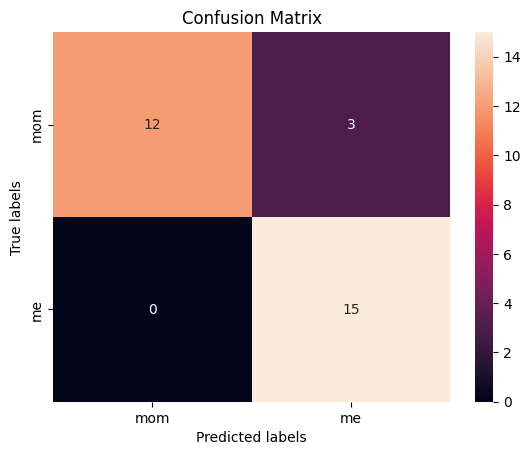

In [78]:
#plot the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_test, y_pred)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['mom', 'me']); ax.yaxis.set_ticklabels(['mom', 'me']);


In [ ]:
#compute the logistic regression coefficients
coefficients = logreg.coef_
print(coefficients)

[[-0.9052666  -0.81441449 -0.39806803 -0.40540073]]


Text(0.5, 0, 'Mean of ZCR')

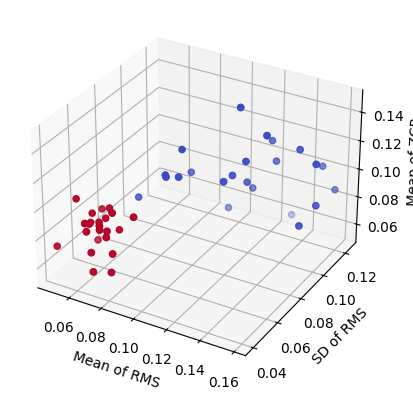

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[:,0], x_train[:,1], x_train[:,3], c=y_train, cmap=plt.cm.coolwarm)
ax.set_xlabel('Mean of RMS')
ax.set_ylabel('SD of RMS')
ax.set_zlabel('Mean of ZCR')
#fig.savefig('3d_plot.png')



AUC Score: 0.8977777777777778


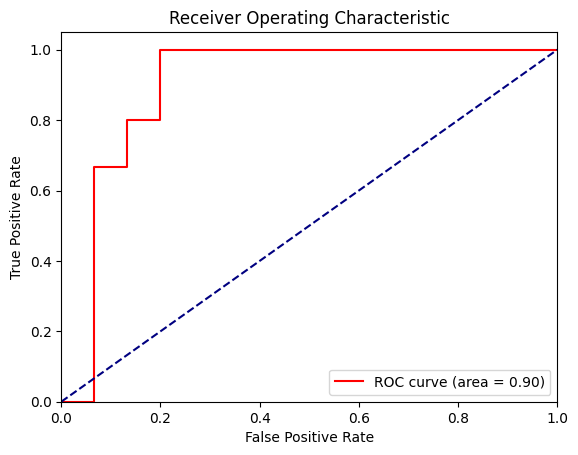

In [76]:
from sklearn.metrics import roc_auc_score, roc_curve

# Make predictions on test set
y_pred = logreg.predict(x_test)

# Compute predicted probabilities for test set
y_scores = logreg.predict_proba(x_test)[:, 1]

# Compute AUC score
auc_score = roc_auc_score(y_test, y_scores)
print('AUC Score:', auc_score)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plot ROC curve
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [73]:
#using another model to compare the results

# Initialize a random forest classifier with max_depth=2 and 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rfc, x_train, y_train, cv=5)

# Print the mean accuracy and standard deviation of the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())


Cross-validation scores: [1.         0.85714286 0.92857143 1.         1.        ]
Mean accuracy: 0.9571428571428571
Standard deviation: 0.05714285714285716


In [79]:
#using another model to classify the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(clf.score(x_test, y_test)))

#plot the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_test, y_pred)
print(cm)


Accuracy of random forest classifier on test set: 0.90
[[12  3]
 [ 0 15]]


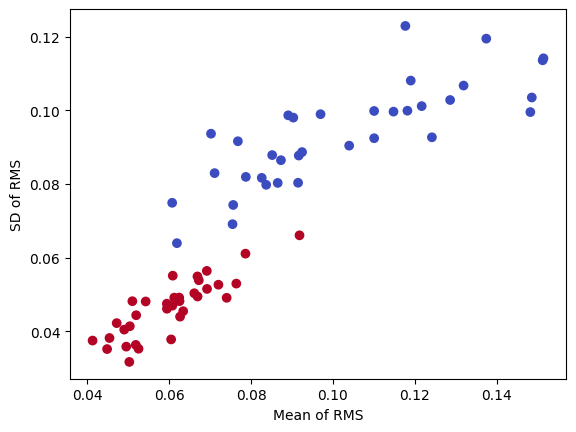

In [64]:
# plot the scatter plot of the data using only the first two features and add legend for the classes
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, cmap=plt.cm.coolwarm)
plt.xlabel('Mean of RMS')
plt.ylabel('SD of RMS')
plt.show()

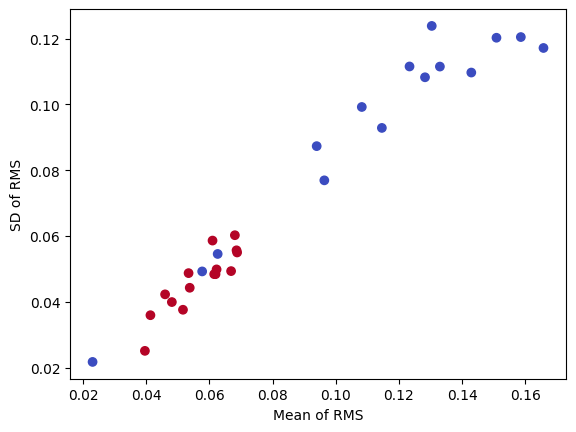

In [65]:
# plot the scatter plot of the data using only the first two features and add legend for the classes
plt.scatter(x_test[:,0], x_test[:,1], c=y_test, cmap=plt.cm.coolwarm)
plt.xlabel('Mean of RMS')
plt.ylabel('SD of RMS')
plt.show()

In [92]:
#calculating precisio, recall and f1 score

print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1: {:.2f}'.format(f1_score(y_test, y_pred)))

Precision: 0.83
Recall: 1.00
F1: 0.91
